# LLM - Detect AI Generated Text
> Identify which essay was written by a large language model

<img src="https://user-images.githubusercontent.com/36858976/279902422-b365f6ef-ef01-49ac-af7f-0bc2ca3ba835.png">

# 🎯 | Motivation

* In this notebook, we will demonstrate the usage of the multi-backend capabilities of `KerasCore` and `KerasNLP` for the **Detect Fake Text** infernece.

# 📓 | Notebooks

* Train: [Detect Fake Text: KerasNLP [TF/Torch/JAX][Train]](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train)
* Infer: [Detect Fake Text: KerasNLP [TF/Torch/JAX][Infer]](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-infer)

# 🛠 | Install Libraries 

In [1]:
# !pip install /kaggle/input/llm-science-exam-lib-ds/keras_core-0.1.7-py3-none-any.whl --no-deps
# !pip install /kaggle/input/llm-science-exam-lib-ds/keras_nlp-0.6.2-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # or "tensorflow" or "torch"

import keras_nlp
import keras_core as keras 
import keras_core.backend as K


# import jax
import torch
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
import gc

Using PyTorch backend.


## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)
torch.cuda.is_available()

TensorFlow: 2.10.1
Keras: 0.1.7
KerasNLP: 0.6.3


True

# ⚙️ | Configuration

In [4]:
class CFG:
    # TEST_PATH = './kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv'
    TEST_PATH = './kaggle/input/feedback-prize-effectiveness/train.csv'
    test_att = { # Test csv's attribute name
        'id': 'discourse_id', 
        'text': 'discourse_text',
        'label': 0 # If 0 or 1, then create a new label where all values are 0 or 1
    }
    VACAB_PATH = './kaggle/Model/keras-nlp-deberta-v3-base-en-vocab-ds/vocab.spm'
    CKPT_PATH = "./kaggle/working/model/fold1.keras"  # Name of pretrained models
    INFER_PATH = './kaggle/working/infer/'
    num_of_testdata = 2000 # Num of test dataset
    verbose = 0  # Verbosity
    device = 'GPU'  # Device
    seed = 42  # Random seed
    batch_size = 10  # Batch size
    drop_remainder = True  # Drop incomplete batches
    sequence_length = 200  # Input sequence length
    class_names = ['real','fake']  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [5]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU). 

In [6]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [7]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
> Running on GPU | Num of GPUs:  1


# 📁 | Dataset Path 

# 📖 | Meta Data 
* `{test|train}_essays.csv`
    * `id` - A unique identifier for each essay.
    * `prompt_id` - Identifies the prompt the essay was written in response to.
    * `text` - The essay text itself.
    * `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.
* **sample_submission.csv** - is the valid sample submission.

## Test Data

In [8]:
def make_df(is_train):
    if is_train:
        read_path = CFG.TRAIN_PATH
        data_att = CFG.train_att
        sample_num = CFG.num_of_traindata
    else:
        read_path = CFG.TEST_PATH
        data_att = CFG.test_att
        sample_num = CFG.num_of_testdata
        
    read_df = pd.read_csv(read_path) 
    if data_att['label'] == 0 or data_att['label'] == 1:
        read_df = read_df.sample(sample_num)
        read_df['label'] = data_att['label']
    else:
        read_df = pd.concat([
            read_df[read_df[data_att['label']]==0].sample(sample_num // 2),
            read_df[read_df[data_att['label']]==1].sample(sample_num // 2)
        ])
        read_df['label'] = read_df[data_att['label']]
        
    if data_att['id'] is None:
        read_df['id'] = range(sample_num)
    else:
        read_df['id'] = read_df[data_att['id']]
        
    return_df = pd.DataFrame({
        'id': read_df['id'],
        'text': read_df[data_att['text']],
        'label': read_df['label']
    })
    
    return return_df

In [9]:
# Display information about the train data
test_df = make_df(False)
print("# Test Data: {:,}".format(len(test_df)))
print("# Sample:")
display(test_df.head(2))

# Test Data: 2,000
# Sample:


,id,text,label
9577,f65ff4205d66,The hands free law can affect you in a positiv...,0
34254,c9ad8f71a02e,"if I'm not sure what college I want to attend,...",0


# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [10]:
tokenizer= keras_nlp.models.DebertaV3Tokenizer(CFG.VACAB_PATH)
preprocessor= keras_nlp.models.DebertaV3Preprocessor(tokenizer, sequence_length=CFG.sequence_length)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [11]:
outs = preprocessor(test_df.text.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [12]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [13]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  augment=False, repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=5))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/test Dataset

The function below generates the training and testation datasets for a given fold.

In [14]:
def get_test_dataset(test_df):
    test_texts = test_df.text.tolist()  # Extract testation texts
    
    # Build testation dataset
    test_ds = build_dataset(test_texts, labels=None,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(test_df)), cache=False,
                             shuffle=False, drop_remainder=False, repeat=False)
    
    return test_ds  # Return datasets and dataframes

# 🤖 | Modeling



In [15]:
def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        load_weights=False,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    inputs = classifier.input
    logits = classifier(inputs)
        
    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    return model

## Ckpt processing
For some reason, `keras.models.load_model` requires write access as `/kaggle/input` doesn't have that access it throws error. Workaround is to simply copy the `ckpts` to other directory then load the model.

In [16]:
# Get the checkpoint directory and name
CKPT_PATH = CFG.CKPT_PATH
# ckpt_name = 'daigt-kerasnlp-ckpt'

# Copy the checkpoints to a new directory in the /kaggle directory
# !cp -r {CKPT_PATH} /kaggle/{ckpt_name}

# List all the checkpoint paths in the new directory
# new_ckpt_dir = f"/kaggle/{ckpt_name}"
new_ckpt_dir = CKPT_PATH
ckpt_paths = glob(os.path.join(new_ckpt_dir, '*.keras'))

print("Total CKPT:", len(ckpt_paths))

Total CKPT: 0


# 🧪 | Prediction

In [17]:
def check_prediction(pred_prob, origin_df, file_name):
    pred_label = (pred_prob > 0.5).astype(int).squeeze()
    print(f"Predict Shape: {pred_label.shape}")
    print("# Predictions\n")
    for i in range(3):
        row = test_df.iloc[i]
        text  = row.text
        pred_answer = CFG.label2name[pred_label[i]]
        print(f"❓ Text {i+1}:\n{text}\n")
        print(f"🤖 Predicted: {pred_answer}\n")
        print("-"*90, "\n")
    sub_df = origin_df.copy()

    # Add the formatted predictions to the submission DataFrame
    sub_df["pred_prob"] = pred_prob.squeeze()
    sub_df["pred_label"] = pred_label
    sub_df["correct"] = sub_df["pred_label"] == sub_df["label"]
    
    # Display the first 2 rows of the submission DataFrame
    sub_df.head(2)
    
    # Display Acc
    total_cor = sub_df["correct"].sum()
    print(f'Total Correct: {total_cor} / {len(sub_df)}')
    print(f'Acc: {(total_cor * 100) / len(sub_df):.2f} %')
    
    if file_name:
        sub_path = f'{CFG.INFER_PATH}/{file_name}.csv'
        if os.path.exists(sub_path):
            i = 1
            sub_path = f'{CFG.INFER_PATH}/{file_name}{i}.csv'
            # 새로운 파일 이름 생성
            while os.path.exists(sub_path):
                i += 1
                sub_path = f'{CFG.INFER_PATH}/{file_name}{i}.csv'
        elif not os.path.exists(CFG.INFER_PATH):
            os.makedirs(CFG.INFER_PATH)
        sub_df.to_csv(f'{sub_path}',index=False)
        print(f'파일이 {sub_path}에 저장되었습니다.')
        
    return sub_df

## Load CheckPoint Model

In [18]:
# # Build model
# model = build_model()

print(CFG.CKPT_PATH)
model = keras.models.load_model(
    CFG.CKPT_PATH,
    compile=False,
)
#     model.load_weights(ckpt_path)

./kaggle/working/model/fold1.keras


C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_core\src\trainers\trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(
C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_core\src\saving\serialization_lib.py:713: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


## Inference

In [19]:
# Get the test dataset
test_ds = get_test_dataset(test_df)

# Generate predictions using the model
pred_result = model.predict(
    test_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(test_df)),  # Set batch size
    verbose=1
)
del model
gc.collect()

200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step


10126

## Check Prediction

In [20]:
submission = check_prediction(pred_result, test_df, 'prize_infer')

Predict Shape: (2000,)
# Predictions

❓ Text 1:
The hands free law can affect you in a positive or negative way. 

🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 2:
if I'm not sure what college I want to attend, and I ask one friend where I should go, they might say "George Mason" as a suggestion. But if George Mason is not in fact the best college for me, even though the person I asked was trying to help, that one opinion could sway me to go there anyway and not have the best experience. But yet if I go to ten people to advice, including the person who suggested George Mason, they might be the only one who would say that and maybe five of the other people I asked might say Virginia Tech, and I would decide to go to Virginia Tech instead of to George Mason, and I would overall be happier and maybe even get better grades. Then I would be more successful because I went to multiple people before I made a decision that

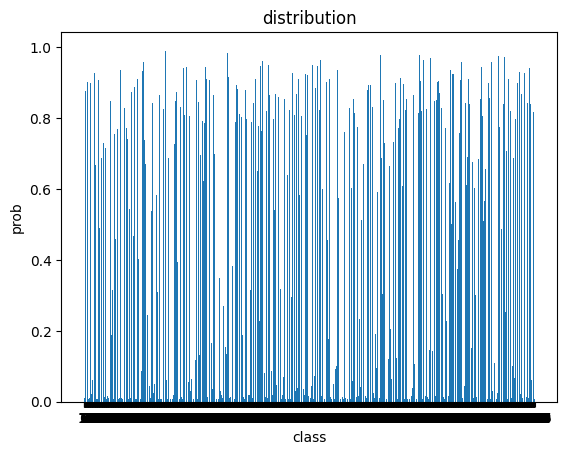

In [21]:
# 각 클래스의 인덱스
classes = np.arange(len(pred_result))

# 확률 분포 시각화
plt.bar(classes, pred_result[:, 0])
plt.xlabel('class')
plt.ylabel('prob')
plt.title('distribution')
plt.xticks(classes)
plt.show()